# Class Labels

In [21]:
class_names = [
    "T-shirt/top",    # 0
    "Trouser",        # 1
    "Pullover",       # 2
    "Dress",          # 3
    "Coat",           # 4
    "Sandal",         # 5
    "Shirt",          # 6
    "Sneaker",        # 7
    "Bag",            # 8
    "Ankle boot"      # 9
]

In [1]:
import sys

assert sys.version_info >= (3, 7)
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# 1-Forward Process

In [2]:
import matplotlib as plt

In [3]:
import tensorflow as tf

In [4]:
import numpy as np

In [5]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 1s 0us/step


In [6]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Variance Scheduler (Producing Noise at different time steps)

In [7]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)  # extra code – for reproducibility
T = 5500
alpha, alpha_cumprod, beta = variance_schedule(T)

# Preparing Dataset

# Prepare Inputs to model , which are Noisy inputs and time which noise was added to raw input in the markov-chain process

In [ ]:
# def prepare_batch(X):
#     X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from –1 to +1
#     X_shape = tf.shape(X)
#     t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
#     alpha_cm = tf.gather(alpha_cumprod, t)
#     alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
#     noise = tf.random.normal(X_shape)
#     return {
#         "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
#         "time": t,
#     }, noise

In [ ]:
# def prepare_dataset(X, batch_size=32, shuffle=False):
#     ds = tf.data.Dataset.from_tensor_slices(X)
#     if shuffle:
#         ds = ds.shuffle(10_000)
#     return ds.batch(batch_size).map(prepare_batch).prefetch(1)

# tf.random.set_seed(43)  # extra code – ensures reproducibility on CPU
# train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
# valid_set = prepare_dataset(X_valid, batch_size=32)

In [8]:
def prepare_batch(X, y):  # ← ADD y parameter
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
        "class_label": y,  # ← ADD class labels
    }, noise

def prepare_dataset(X, y, batch_size=32, shuffle=False):  # ← ADD y parameter
    ds = tf.data.Dataset.from_tensor_slices((X, y))  # ← Tuple of (X, y)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(lambda x, y: prepare_batch(x, y)).prefetch(1)

In [9]:
# Modified
train_set = prepare_dataset(X_train, y_train, batch_size=32, shuffle=True)  # ← ADD y_train
valid_set = prepare_dataset(X_valid, y_valid, batch_size=32)  # ← ADD y_valid

# Helper functions

In [10]:

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Original images


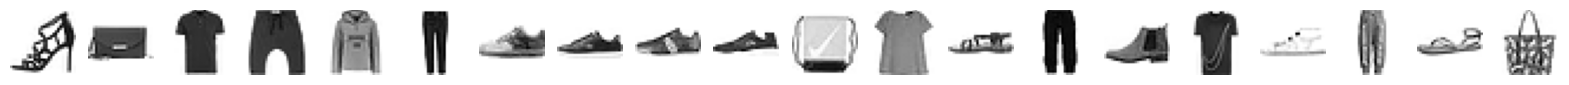

Time steps: [1501 2608 4207 1211 4606 2276 4096 3963 2516 1201   75 5245 1201 2959
 5333 1346  888 2565  860 1976]
Noisy images


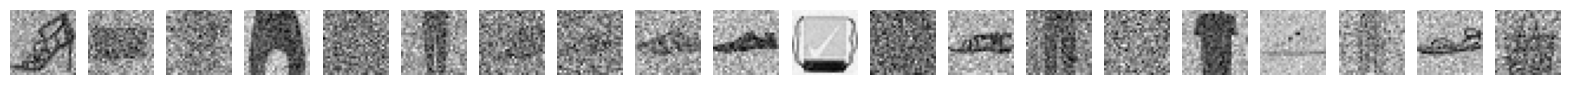

Noise to predict


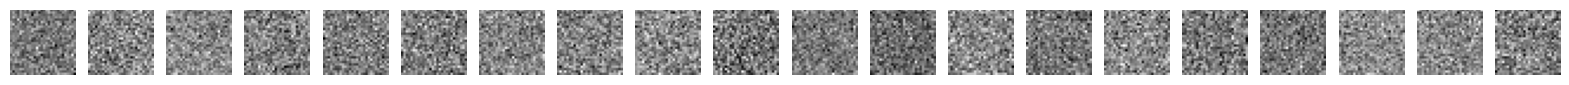

In [11]:
# extra code – just a quick sanity check
import matplotlib.pyplot as plt

def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("Original images")
plot_multiple_images(X_original[:20].numpy())
plt.show()
print("Time steps:", X_dict["time"].numpy()[:20])
print("Noisy images")
plot_multiple_images(X_dict["X_noisy"][:20].numpy())
plt.show()
print("Noise to predict")
plot_multiple_images(Y_noise[:20].numpy())
plt.show()

# Time Encoding

In [12]:
# extra code – implements a custom time encoding layer

embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

# U-NET Model Implementation

In [13]:
def build_conditional_diffusion_model(num_classes=10):  # ← ADD num_classes parameter
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    class_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="class_label")  # ← NEW INPUT

    time_enc = TimeEncoding(T, embed_size)(time_input)
    class_enc = tf.keras.layers.Embedding(num_classes, embed_size)(class_input)  # ← NEW EMBEDDING

    # Combine time and class embeddings
    combined_enc = time_enc + class_enc  # ← COMBINE EMBEDDINGS

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    # CHANGE: Use combined_enc instead of time_enc
    time = tf.keras.layers.Dense(dim)(combined_enc)  # ← USE combined_enc
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z

    skip = Z
    cross_skips = []

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2, padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        # CHANGE: Use combined_enc instead of time_enc
        time = tf.keras.layers.Dense(dim)(combined_enc)  # ← USE combined_enc
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        # CHANGE: Use combined_enc instead of time_enc
        time = tf.keras.layers.Dense(dim)(combined_enc)  # ← USE combined_enc
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]

    # CHANGE: Add class_input to model inputs
    return tf.keras.Model(
        inputs=[X_noisy, time_input, class_input],  # ← ADD class_input
        outputs=[outputs]
    )

In [15]:
tf.random.set_seed(42)
model = build_conditional_diffusion_model(num_classes=10)  # ← Specify 10 classes for Fashion-MNIST
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Nadam())

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_conditional_diffusion_model.keras",
                                                   save_best_only=True)

history = model.fit(train_set, validation_data=valid_set, epochs=100,
                    callbacks=[checkpoint_cb])

Epoch 1/100
1719/1719 [==============================] - 86s 34ms/step - loss: 0.1031 - val_loss: 0.0675
Epoch 2/100
1719/1719 [==============================] - 56s 32ms/step - loss: 0.0609 - val_loss: 0.0563
Epoch 3/100
1719/1719 [==============================] - 51s 30ms/step - loss: 0.0527 - val_loss: 0.0505
Epoch 4/100
1719/1719 [==============================] - 47s 27ms/step - loss: 0.0484 - val_loss: 0.0456
Epoch 5/100
1719/1719 [==============================] - 55s 32ms/step - loss: 0.0463 - val_loss: 0.0440
Epoch 6/100
1719/1719 [==============================] - 46s 26ms/step - loss: 0.0448 - val_loss: 0.0446
Epoch 7/100
1719/1719 [==============================] - 47s 27ms/step - loss: 0.0437 - val_loss: 0.0442
Epoch 8/100
1719/1719 [==============================] - 46s 27ms/step - loss: 0.0433 - val_loss: 0.0424
Epoch 9/100
1719/1719 [==============================] - 46s 27ms/step - loss: 0.0428 - val_loss: 0.0419
Epoch 10/100
1719/1719 [==============================]

# Inference Stage of Diffusion Model

In [16]:
def generate(model, class_label=None, batch_size=32):
    """
    Generate images conditioned on class_label.

    Args:
        model: The trained conditional diffusion model
        class_label: Integer from 0-9 for Fashion-MNIST class, or None for random
        batch_size: Number of images to generate
    """
    X = tf.random.normal([batch_size, 28, 28, 1])

    # If no class specified, generate random classes
    if class_label is None:
        class_labels = tf.random.uniform([batch_size], minval=0, maxval=10, dtype=tf.int32)
    else:
        class_labels = tf.constant([class_label] * batch_size, dtype=tf.int32)

    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))

        # ADD class_label to model inputs
        X_noise = model({
            "X_noisy": X,
            "time": tf.constant([t] * batch_size),
            "class_label": class_labels  # ← ADD class labels
        })

        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

# Examples

In [18]:
# Generate 32 random images with random classes
X_gen = generate(model)

# Generate 32 T-shirts (class 0)
X_tshirts = generate(model, class_label=0, batch_size=32)

# # Generate 32 Trousers (class 1)
# X_trousers = generate(model, class_label=1, batch_size=32)

# # Generate 32 Dresses (class 3)
# X_dresses = generate(model, class_label=3, batch_size=32)

# # Generate one of each class
# for class_id in range(10):
#     X_class = generate(model, class_label=class_id, batch_size=4)
#     plot_multiple_images(X_class.numpy(), 4)
#     plt.suptitle(f"Class {class_id}: {class_names[class_id]}")
#     plt.show()

t = 1 

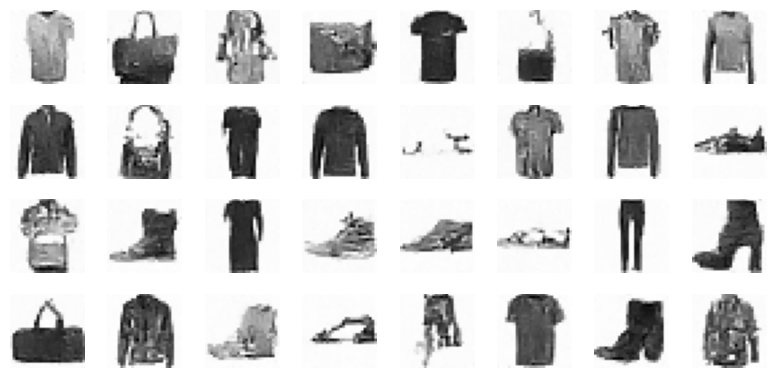

In [19]:
plot_multiple_images(X_gen.numpy(), 8)
save_fig("random_ddpm_generated_images_plot")
plt.show()

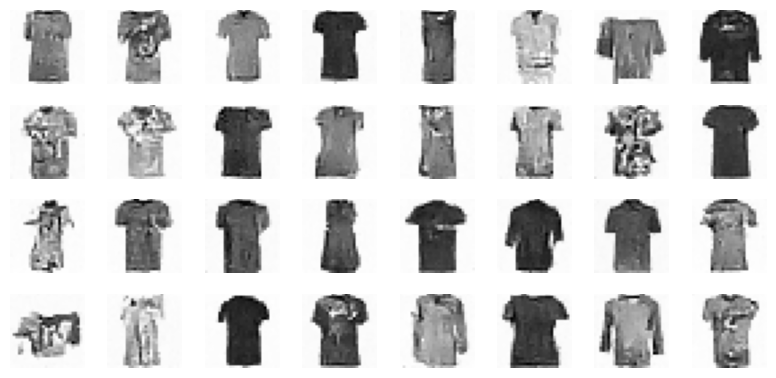

In [20]:
plot_multiple_images(X_tshirts.numpy(), 8)
save_fig("Tshirts_ddpm_generated_images_plot")
plt.show()

t = 1 

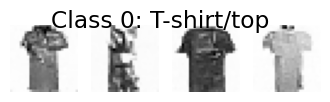

t = 1 

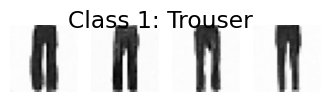

t = 1 

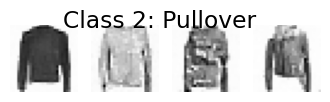

t = 1 

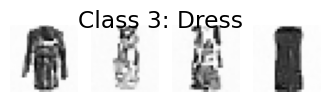

t = 1 

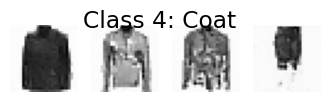

t = 30 

In [ ]:
# Generate one of each class
for class_id in range(10):
    X_class = generate(model, class_label=class_id, batch_size=4)
    plot_multiple_images(X_class.numpy(), 4)
    plt.suptitle(f"Class {class_id}: {class_names[class_id]}")
    plt.show()